In [1]:
!echo 'Current env settings:'
!pip freeze | grep Keras
!pip freeze | grep sorflow

Current env settings:
Keras==2.1.5
tensorflow==1.6.0


In [2]:
import numpy as np
import keras as K
from keras.models import Model, Sequential
from keras.layers import Embedding, Dense, Input,LSTM, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences

import matplotlib.pyplot as plt

from layers.crf import ChainCRF
from utils import loader
from utils import sequential
from utils import featurizer

EMBEDDING_PATH = 'levy_deps.words'
WV_DIMENSIONS = 300

MAX_SEQUENCE_LEN = 10
BATCH_SIZE = 32
DROPOUT_PROB = 0.25
LSTM_OUTPUT_SIZE = 100

MODEL_DUMP = 'trained_model.h5'

DATASET_TRAIN = 'dataset/train.txt'
DATASETS_DEV  = 'dataset/dev.txt'

/home/lzfelix/miniconda3/envs/example/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def plot_curves(model_data):
    plt.figure(figsize=(20, 5))

    history = model_data.history

    plt.subplot(121)
    ran = np.arange(len(history['val_loss']))

    plt.grid(alpha=0.3)
    plt.plot(ran, history['loss'], '-or', alpha=0.5)
    plt.plot(ran, history['val_loss'], '-ob', alpha=0.5)
    plt.legend(['Train', 'Dev'], loc='best')
    plt.title('Loss');

    plt.subplot(122)
    ran = np.arange(len(history['sparse_categorical_accuracy']))

    plt.grid(alpha=0.3)
    plt.plot(ran, history['sparse_categorical_accuracy'], '-or', alpha=0.5)
    plt.plot(ran, history['val_sparse_categorical_accuracy'], '-ob', alpha=0.5)
    plt.legend(['Train', 'Dev'], loc='best')
    plt.title('Accuracy');
    
    plt.show()

In [4]:
x_train, y_train = loader.load_dataset(DATASET_TRAIN)
x_dev,   y_dev   = loader.load_dataset(DATASETS_DEV)

vocab = loader.build_vocabulary(x_train)
wv, word2index = loader.load_word_embeddings(EMBEDDING_PATH,
                                             WV_DIMENSIONS)

print('Demo sample:\n')
print('Text:   {}'.format(x_train[-1]))
print('Labels: {}'.format(y_train[-1]))

assert len(x_train) == len(y_train)
assert len(x_dev) == len(y_dev)

Demo sample:

Text:   ['I', 'will', 'never', 'return', 'there', 'again', '(', 'and', 'now', 'have', 'some', 'serious', 'doubts', 'about', 'the', 'quality', 'of', 'work', 'they', 'actually', 'performed', 'on', 'my', 'car', ')', '.']
Labels: ['PRON', 'AUX', 'ADV', 'VERB', 'ADV', 'ADV', 'PUNCT', 'CONJ', 'ADV', 'VERB', 'DET', 'ADJ', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADP', 'NOUN', 'PRON', 'ADV', 'VERB', 'ADP', 'PRON', 'NOUN', 'PUNCT', 'PUNCT']


In [5]:
pos_encoder = sequential.SequenceEncoder()
case_encoder = sequential.SequenceEncoder()

x_train_emb = featurizer.map_words(x_train, word2index)
x_dev_emb   = featurizer.map_words(x_dev, word2index)

y_train_emb = pos_encoder.fit_transform(y_train)
y_dev_emb   = pos_encoder.transform(y_dev)

# padding && picking just part of the data
# pad sequences and discard words from the RIGHT
pad = lambda x: pad_sequences(x, MAX_SEQUENCE_LEN,
                              truncating='post', padding='post')

x_train_emb = pad(x_train_emb)
y_train_emb = pad(y_train_emb)

x_dev_emb = pad(x_dev_emb)
y_dev_emb = pad(y_dev_emb)

# making output episodic
y_train_emb = np.expand_dims(y_train_emb, -1)
y_dev_emb = np.expand_dims(y_dev_emb, -1)

print('Statistics:')
print('\t# words:   {}'.format(len(word2index)))
print('\t# classes: {}'.format(len(pos_encoder.classes_)))
print('\t# train samples: {}'.format(len(x_train)))
print('\t# dev   samples: {}'.format(len(x_dev)))

print('\nDemo sample: ')
print('\tText:   {}'.format(x_train[-1][:MAX_SEQUENCE_LEN]))
print('\tTokens: {}'.format(x_train_emb[-1]))
print('\tLabels: {}'.format(np.ravel(y_train_emb[-1])))

Statistics:
	# words:   174020
	# classes: 17
	# train samples: 12543
	# dev   samples: 2002

Demo sample: 
	Text:   ['I', 'will', 'never', 'return', 'there', 'again', '(', 'and', 'now', 'have']
	Tokens: [ 29 198 948 419  81 537  12   5 313  15]
	Labels: [10  3  2 15  2  2 12  4  2 15]


In [6]:

def build_model(wv, n_classes):
    """
    Builds POS prediction model:
    Embedding -> projection -> CRF
    """
    vocab_size, embedding_dim = wv.shape

    sentence_in = Input(shape=(None,), name='input_sentence')
    word_embedding = Embedding(vocab_size, embedding_dim, weights=[wv],
                       trainable=False, name='embedding')(sentence_in)
    
    projection = Dense(n_classes)(word_embedding)
    
    crf = ChainCRF(name='chain_crf')
    output = crf(projection)
    loss_fun = crf.sparse_loss
    
    model = Model(inputs=[sentence_in], outputs=[output])
    model.summary()
    
    model.compile('nadam', loss_fun,
                  metrics=['sparse_categorical_accuracy'])
    
    return model


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_sentence (InputLayer)  (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         52206000  
_________________________________________________________________
dense_1 (Dense)              (None, None, 17)          5117      
_________________________________________________________________
chain_crf (ChainCRF)         (None, None, 17)          323       
Total params: 52,211,440
Trainable params: 5,440
Non-trainable params: 52,206,000
_________________________________________________________________
Train on 12543 samples, validate on 2002 samples
Epoch 1/5
12543/12543 [==============================] - 15s 1ms/step - loss: 13.6897 - sparse_categorical_accuracy: 0.7987 - val_loss: 15.0362 - val_sparse_categorical_accuracy: 0.8909
Epoch 2/5
12543/12543 [

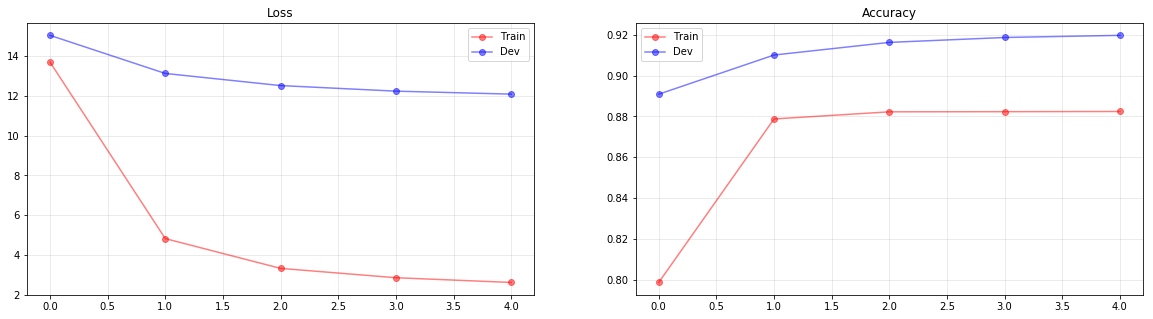

In [7]:
# Model training

n_classes = len(pos_encoder.classes_)
model = build_model(wv, n_classes)

metrics = model.fit(x_train_emb, y_train_emb, BATCH_SIZE, epochs=5,
          validation_data=(x_dev_emb, y_dev_emb));
model.save_weights(MODEL_DUMP)

plot_curves(metrics)


In [8]:
# Loading the dumped model and comparing the results

pred_old = model.predict(x_dev_emb)

new_model = build_model(wv, n_classes)
new_model.load_weights(MODEL_DUMP)
pred_new = new_model.predict(x_dev_emb)

assert np.array_equal(pred_old, pred_new)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_sentence (InputLayer)  (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         52206000  
_________________________________________________________________
dense_2 (Dense)              (None, None, 17)          5117      
_________________________________________________________________
chain_crf (ChainCRF)         (None, None, 17)          323       
Total params: 52,211,440
Trainable params: 5,440
Non-trainable params: 52,206,000
_________________________________________________________________
